# Import & Load Dataset

In [ ]:
# Langkah awal: Import semua library yang dibutuhkan
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Cek apakah pakai GPU atau CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Transformasi: ubah ke tensor & normalisasi (RGB: 3 channel)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalisasi channel RGB
])

# Load dataset CIFAR-10 (training & testing)
batch_size = 10

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# Label Kelas
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Device: cpu


100%|██████████| 170M/170M [00:02<00:00, 72.9MB/s]


# Cek Beberapa Data

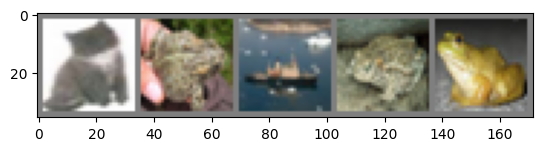

Label: cat frog ship frog frog


In [ ]:
import numpy as np

# Fungsi unnormalize buat visualisasi
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Tampilkan sample gambar
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:5]))
print('Label:', ' '.join(f'{classes[labels[j]]}' for j in range(5)))

# Buat Arsitektur LeNet-5

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)   # RGB: 3 channel
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # hasil pooling dikali
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)           # output: 10 kelas CIFAR-10

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # [3, 32, 32] → [6, 28, 28] → [6, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))   # → [16, 10, 10] → [16, 5, 5]
        x = x.view(-1, 16 * 5 * 5)             # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Training Model LeNet-5 di CIFAR-10

## 1. Inisialisasi Model, Loss Function, Optimizer

In [ ]:
model = LeNet5().to(device)  # Pindahkan model ke CPU/GPU

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training Loop

In [ ]:
epochs = 10
train_losses = []

for epoch in range(epochs):
    running_loss = 0.0
    model.train()  # Set model ke mode training
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

print('Training selesai!')

Epoch 1/10, Loss: 1.5579
Epoch 2/10, Loss: 1.2569
Epoch 3/10, Loss: 1.1317
Epoch 4/10, Loss: 1.0571
Epoch 5/10, Loss: 0.9983
Epoch 6/10, Loss: 0.9527
Epoch 7/10, Loss: 0.9160
Epoch 8/10, Loss: 0.8806
Epoch 9/10, Loss: 0.8522
Epoch 10/10, Loss: 0.8267
Training selesai!


#Evaluasi Akurasi Model LeNet-5

In [ ]:
correct = 0
total = 0
model.eval()  # Set model ke mode evaluasi

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

Accuracy of the network on the 10000 test images: 63.73%


#Evaluasi Per Kelas (Class-wise Accuracy)

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print(f'Akurasi untuk kelas {classes[i]:5s}: {100 * class_correct[i] / class_total[i]:.2f}%')

Akurasi untuk kelas plane: 67.50%
Akurasi untuk kelas car  : 80.50%
Akurasi untuk kelas bird : 46.40%
Akurasi untuk kelas cat  : 45.90%
Akurasi untuk kelas deer : 53.80%
Akurasi untuk kelas dog  : 55.40%
Akurasi untuk kelas frog : 75.10%
Akurasi untuk kelas horse: 69.60%
Akurasi untuk kelas ship : 77.10%
Akurasi untuk kelas truck: 66.00%


#Visualisasi Loss Selama Training
##Plot Grafik Loss

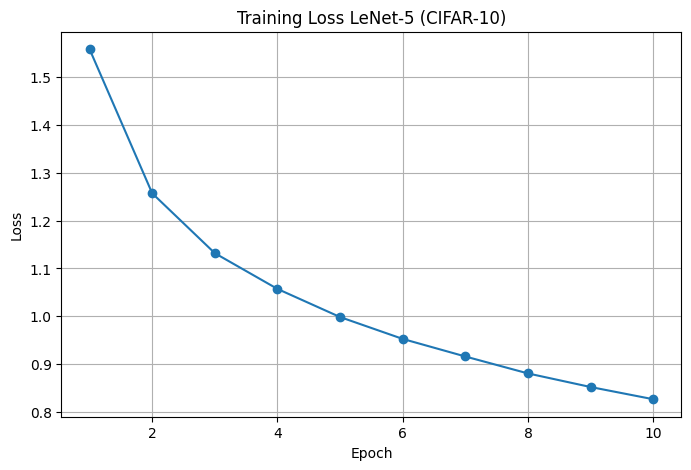

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o')
plt.title('Training Loss LeNet-5 (CIFAR-10)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

#Kesimpulan & Rangkuman Bagian LeNet-5

LANGKAH 7: Kesimpulan & Rangkuman Bagian LeNet-5
Berikut template kesimpulan dan hasil bagian kamu yang bisa langsung kamu masukkan ke laporan/jurnal:

🧾 Kesimpulan Eksperimen LeNet-5 di CIFAR-10
Model LeNet-5 telah berhasil diterapkan dan dilatih pada dataset CIFAR-10 menggunakan 10 epoch. Hasil menunjukkan bahwa model mampu belajar dengan baik, ditandai oleh penurunan loss dari 1.55 ke 0.82, serta akurasi akhir sebesar 63.73% pada data uji.

🔍 Hasil Utama:
Akurasi rata-rata: 63.73%

Akurasi tertinggi: 80.50% (kelas car)

Akurasi terendah: 45.90% (kelas cat)

Grafik loss menunjukkan kurva yang terus menurun selama proses training

🎯 Analisis:
LeNet-5 cukup efektif untuk dataset seperti CIFAR-10 meskipun arsitekturnya sederhana

Model kesulitan membedakan objek dengan bentuk mirip (cat vs dog)

Akurasi tertinggi dicapai pada kelas car, ship, dan frog

📌 Rekomendasi:
LeNet-5 cocok untuk aplikasi klasifikasi ringan dengan data terbatas

Untuk hasil lebih akurat, disarankan menggunakan model yang lebih kompleks seperti ResNet

Kesimpulan Eksperimen Model LeNet-5 pada Dataset CIFAR-10
Dalam eksperimen ini, model Convolutional Neural Network (CNN) klasik LeNet-5 telah berhasil diimplementasikan dan diuji pada dataset CIFAR-10, yang terdiri dari citra RGB berukuran 32x32 piksel dalam 10 kelas objek berbeda. Meskipun LeNet-5 dirancang untuk dataset sederhana seperti MNIST, hasil pengujian menunjukkan bahwa model ini masih memiliki kapabilitas generalisasi yang cukup baik ketika diterapkan pada data visual yang lebih kompleks.

Proses pelatihan dilakukan selama 10 epoch menggunakan fungsi loss CrossEntropy dan optimizer Adam dengan learning rate 0.001. Berdasarkan hasil pelatihan, nilai loss berhasil diturunkan secara signifikan dari 1.55 menjadi 0.82, menunjukkan bahwa model mampu belajar pola representatif dari data secara bertahap. Evaluasi performa terhadap data uji menghasilkan akurasi global sebesar 63.73%, yang dapat dianggap kompetitif untuk model dengan kompleksitas rendah seperti LeNet-5.

Analisis per kelas menunjukkan bahwa model memiliki akurasi tertinggi pada kelas 'car' (80.50%) dan terendah pada kelas 'cat' (45.90%). Disparitas ini mengindikasikan bahwa LeNet-5 lebih efektif dalam mengenali objek dengan fitur bentuk dan warna yang lebih konsisten (seperti mobil atau kapal), namun kurang optimal dalam membedakan kelas dengan karakteristik visual yang lebih ambigu atau tumpang tindih, seperti kucing dan anjing. Hal ini mencerminkan keterbatasan representasional dari arsitektur shallow CNN seperti LeNet-5.

Secara keseluruhan, eksperimen ini membuktikan bahwa LeNet-5 tetap relevan sebagai baseline dalam studi perbandingan arsitektur CNN, terutama untuk tugas klasifikasi dengan sumber daya terbatas. Namun, untuk kebutuhan klasifikasi citra berskala lebih kompleks dan akurasi yang lebih tinggi, disarankan penggunaan model dengan arsitektur yang lebih dalam dan modern seperti AlexNet, VGG, atau ResNet.